# Human Long Promoter Classification with Genomic Pretraining and Fine Tuning

This notebook adds a fine tuning step to the long promoter classification model. For more detail about the fine tuning process, see the [Human 4 Short Promoter Classification with Fine Tuning](https://github.com/kheyer/Genomic-ULMFiT/blob/master/Mammals/Human/Promoter%20Classification%20Short%20Sequences/Human%20Promoters%20Short%20Sequences%203%20Classification%20with%20Fine%20Tuning.ipynb) notebook.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *
from Bio import Seq
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import FeatureLocation, CompoundLocation
import networkx as nx

In [3]:
sys.path.append("../../..")
from utils import *

In [4]:
path = Path('F:/genome/human/')
path_mam = Path('F:/genome/mammals/')

# LM Fine Tune

Here we create a language model corpus from our classification dataset. This basically concatenates all our promoter sequences into a single long string of text. The language model is trained on the concatenated promoter corpus. We need to make sure to create our dataloader with the correct vocabulary.

In [5]:
classification_df = pd.read_csv(path/'human_promoters_long.csv')

In [6]:
classification_df.head()

,Sequence,Target,set
0,ccaGTTGAAAAGTAGAGGCCGAGGACAGAGTTAGACACTCGTTGTC...,1,train
1,ggaagggcgCAAGAGAGGATCAGGGGTCAGCGGCACACCCATGGAG...,1,train
2,TAAAGAAATACAAGGATTCCTCAAGCCCCTCTTCCCTAAAACATGC...,1,train
3,CGCGGGGCCGGGGAAGCCCGCGCGCGTCATCAGCAGCGGCGCCGCG...,1,train
4,TACACAGTAAGGACAGCCGCTGGAGCGCTACGGTCTGACGAACGAG...,1,train


In [7]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']

In [8]:
train_df.shape, valid_df.shape, test_df.shape

((56834, 3), (6316, 3), (7017, 3))

In [9]:
voc = np.load(path/'human_vocab.npy')
model_vocab = GenomicVocab(voc)

In [10]:
tok = Tokenizer(GenomicTokenizer, n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])

In [11]:
data = GenomicTextLMDataBunch.from_df(path, pd.concat([train_df, valid_df]), test_df, bs=400, tokenizer=tok, bptt=70,
                              chunksize=10000, text_cols='Sequence', label_cols='Target', vocab=model_vocab)

In [14]:
config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.25, 
                          hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15, tie_weights=True, out_bias=True)
drop_mult = 0.35

In [15]:
learn = get_model_LM(data, drop_mult, config)

We initialize the model by loading the weights from the human genome language model

In [16]:
learn.load('human_genome_full3');

In [17]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(1025, 400, padding_idx=0)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(1025, 400, padding_idx=0)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=1025, bias=True)
    (output_dp): RNNDropout()
  )
)

In [45]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07


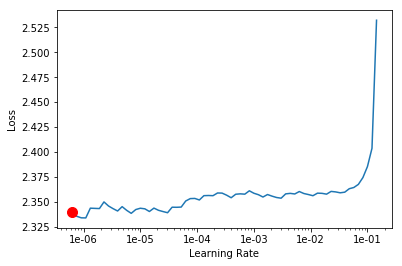

In [52]:
learn.recorder.plot(skip_end=15)

# Training

This model struggled to fine tune on the promoters dataset. I'm not quite sure why. One theory is that the negative examples in the dataset are pulled from random regions of the genome, which might have some degree of randomness to them that is difficult to model. Work on this is ongoing.

In [25]:
learn.fit_one_cycle(20, 5e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,2.356696,2.330364,0.252491
2,2.340881,2.332515,0.251876
3,2.344192,2.336712,0.250246
4,2.347895,2.342645,0.248359
5,2.347407,2.345539,0.247041
6,2.352708,2.347193,0.246687
7,2.348729,2.345288,0.247263
8,2.339016,2.344424,0.247984
9,2.331206,2.342951,0.248438
10,2.326929,2.342566,0.248596


In [26]:
learn.fit_one_cycle(30, 5e-4, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,2.256938,2.350323,0.248744
2,2.237982,2.350533,0.248682
3,2.241673,2.350782,0.248667
4,2.232170,2.350914,0.248650
5,2.239182,2.351265,0.248515
6,2.236457,2.351699,0.248495
7,2.243305,2.352973,0.248276
8,2.249020,2.353207,0.247932
9,2.234074,2.353418,0.248035
10,2.236650,2.354619,0.247947


In [19]:
learn.save('human_LM_long_finetune')
learn.save_encoder('human_LM_long_finetune_enc')

# Classification

In [5]:
classification_df = pd.read_csv(path/'human_promoters_long.csv')

In [6]:
classification_df.head()

,Sequence,Target,set
0,ccaGTTGAAAAGTAGAGGCCGAGGACAGAGTTAGACACTCGTTGTC...,1,train
1,ggaagggcgCAAGAGAGGATCAGGGGTCAGCGGCACACCCATGGAG...,1,train
2,TAAAGAAATACAAGGATTCCTCAAGCCCCTCTTCCCTAAAACATGC...,1,train
3,CGCGGGGCCGGGGAAGCCCGCGCGCGTCATCAGCAGCGGCGCCGCG...,1,train
4,TACACAGTAAGGACAGCCGCTGGAGCGCTACGGTCTGACGAACGAG...,1,train


In [7]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']

In [8]:
train_df.shape, valid_df.shape, test_df.shape

((56834, 3), (6316, 3), (7017, 3))

In [9]:
voc = np.load(path/'human_vocab.npy')
model_vocab = GenomicVocab(voc)

In [10]:
tok = Tokenizer(GenomicTokenizer, n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, valid_df, tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Target', bs=100)

In [13]:
clas_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.4, 
                       hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
drop_mult = 0.4

In [14]:
learn = get_model_clas(data_clas, drop_mult, clas_config, wd=5e-3)

In [15]:
learn.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(1025, 400, padding_idx=0)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(1025, 400, padding_idx=0)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1150, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1150, 1150, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1150, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.16000000000000003)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=1e

In [16]:
learn.load_encoder('human_LM_long_finetune_enc')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.51E-03


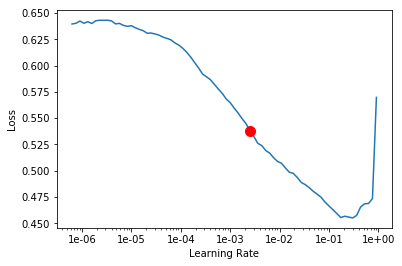

In [17]:
learn.lr_find()
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(2, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.336710,0.319872,0.866371
2,0.325308,0.302698,0.867479


In [18]:
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.314752,0.333041,0.834389
2,0.288861,0.271386,0.883946
3,0.266389,0.272097,0.887904


In [19]:
learn.freeze_to(-3)
learn.fit_one_cycle(3, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.255436,0.269079,0.886954
2,0.233662,0.274132,0.892495
3,0.198916,0.280022,0.893445


In [20]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.191261,0.290439,0.892179
2,0.188928,0.283417,0.894395
3,0.167879,0.290744,0.894554


In [21]:
learn.save('human_long_finetune')

In [22]:
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, test_df, tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Target', bs=100)
learn.data = data_clas

In [23]:
get_scores(learn)

Accuracy: 0.8894114293857774
False Positives: 0.04574604531851219
False Negatives: 0.06484252529571041
Recall: 0.8462837837837838
Precision: 0.886411889596603
Specificity: 0.9208774956864678
MCC: 0.772485124320769


Here fine-tuning only resulting in a small performance improvement. I believe this is due to the issues with training the fine-tuned language model. Once I figure out what the issue is, I will revisit this.